In [2]:
%load_ext autoreload
%autoreload 1

In [101]:
# Familiar imports
import numpy as np
import pandas as pd

# For ordinal encoding categorical variables, splitting data
from sklearn.preprocessing import OrdinalEncoder, OneHotEncoder
from sklearn.model_selection import train_test_split, cross_val_score

# For training random forest model
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error

import os
from os import path
import random
# import zipfile
import tqdm
%aimport common
%aimport common_scoring
%aimport common_prediction
import seaborn as sns
import matplotlib.pyplot as plt
import xgboost
from datetime import datetime
import itertools
import json
import functools
from sklearn.feature_selection import mutual_info_regression
import logging
import matplotlib.pyplot as plt

from sklearn.compose import ColumnTransformer
from sklearn.datasets import fetch_openml
from sklearn.pipeline import Pipeline
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import train_test_split, GridSearchCV

import webbrowser

FN = path.join(os.getcwd(),"20210827-nn")

In [35]:
X,y,X_test = common.setup()
X_train, X_valid, y_train, y_valid = train_test_split(X, y, random_state=0)

SUBMISSION_DATE=datetime(2021,8,26)

In [39]:
logging.warning({k:v.nunique() for k,v in X.items() if k.startswith("cat")})

In [65]:
small_card_cats = [cn for cn,s in X.items() if cn.startswith("cat") and s.nunique()<=4]
num_cats = [cn for cn in X if cn.startswith("cont")]
big_card_cats = [cn for cn in X if cn not in small_card_cats and cn.startswith("cat")]

# small_card_cats
numeric_transformer = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='median')),
    ('scaler', StandardScaler())])

categorical_transformer = OneHotEncoder(handle_unknown='ignore')

preprocessor = ColumnTransformer(
    transformers=[
        ('num', numeric_transformer, num_cats),
        ('cat', categorical_transformer, small_card_cats),
        ('drop', "drop", big_card_cats),
    ]
)

In [69]:
transformed_colnames = [cn for cn in X if cn.startswith("cont")]+list(itertools.chain(*[[f"{cn}_{i}" for i in range(X[cn].nunique())] for cn in small_card_cats]))
X_train_processed = pd.DataFrame(data=preprocessor.fit_transform(X_train),columns=transformed_colnames)
X_valid_processed = pd.DataFrame(data=preprocessor.transform(X_valid),columns=transformed_colnames)

In [116]:
from tensorflow import keras
from tensorflow.keras import layers
def build_model():
    model = keras.Sequential([
        layers.BatchNormalization(),
        layers.Dense(512, activation='relu', input_shape=[X_train_processed.shape[1]]),
        layers.Dropout(rate=0.3),
        layers.BatchNormalization(),
        layers.Dense(512, activation='relu'),
        layers.Dropout(rate=0.3),
        layers.BatchNormalization(),
        layers.Dense(512, activation='relu'),
        layers.Dropout(rate=0.3),
        layers.BatchNormalization(),
        layers.Dense(1),
    ])
    model.compile(
        optimizer='adam',
        loss='mae',
    )
    return model
model = build_model()

CPU times: user 26min 49s, sys: 10min 10s, total: 36min 59s
Wall time: 9min 18s


0.7429681170990439

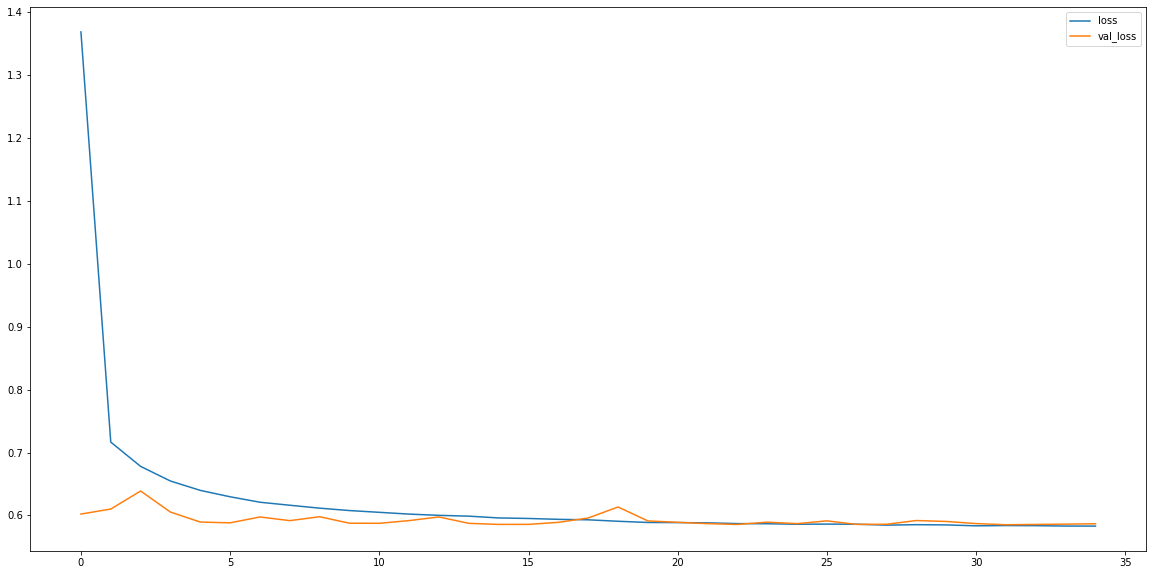

In [110]:
%%time
from tensorflow.keras.callbacks import EarlyStopping

early_stopping = EarlyStopping(
    min_delta=0.001, # minimium amount of change to count as an improvement
    patience=20, # how many epochs to wait before stopping
    restore_best_weights=True,
)

history = model.fit(
    X_train_processed, y_train,
    validation_data=(X_valid_processed, y_valid),
    batch_size=256,
#     epochs=10,
    epochs=100,
    callbacks=[early_stopping], 
    verbose=0,
)

# _,ax = plt.subplots(figsize=(20,10))
# pd.DataFrame(history.history).plot(ax=ax)

np.sqrt(mean_squared_error(model.predict(X_valid_processed),y_valid))

<AxesSubplot:>

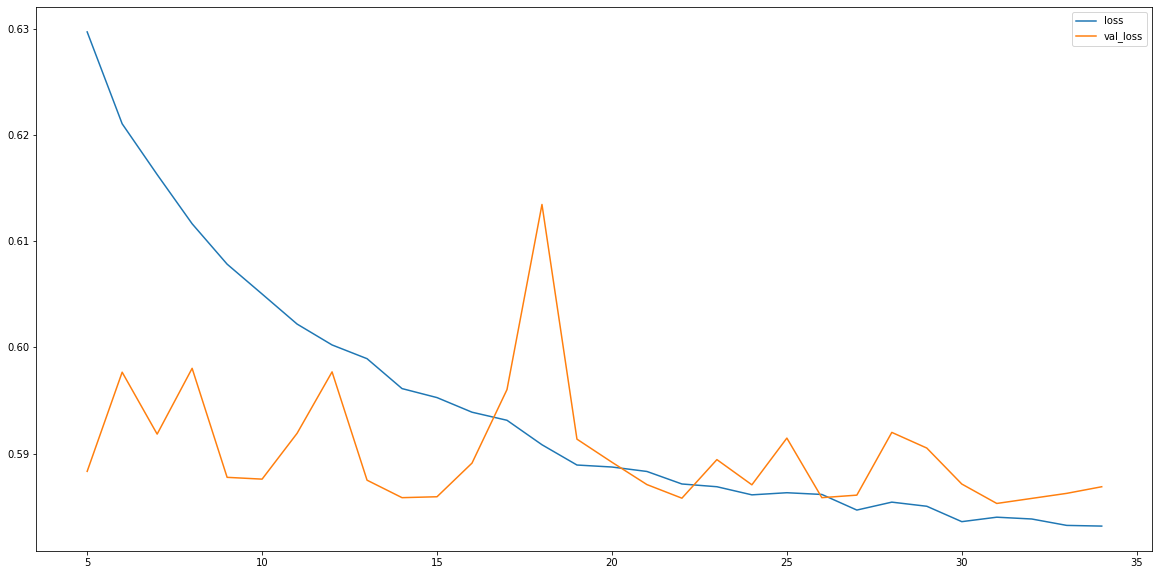

In [112]:
_,ax = plt.subplots(figsize=(20,10))
pd.DataFrame(history.history)[5:].plot(ax=ax)

In [111]:
common.call_me("nn done")

In [89]:
0.7432137035971532

0.7432137035971532

In [119]:
%time
from keras.wrappers.scikit_learn import KerasRegressor

print(datetime.now().isoformat())
sk_params = dict(
#         validation_data=(X_valid_processed, y_valid),
    batch_size=256,
#     epochs=10,
    epochs=100,
#     callbacks=[early_stopping], 
#     verbose=0,
)
common.score_dataset(X,y,
                     model=Pipeline(steps=[
                         ("preprocessor",preprocessor),
                         ("predictor",KerasRegressor(build_fn=build_model,**sk_params))
                     ]), 
                    )

CPU times: user 2 µs, sys: 2 µs, total: 4 µs
Wall time: 7.87 µs
2021-08-29T22:05:24.668587
Epoch 1/100
938/938 [==============================] - 13s 13ms/step - loss: 1.3474
Epoch 2/100
938/938 [==============================] - 18s 19ms/step - loss: 0.7114
Epoch 3/100
938/938 [==============================] - 15s 16ms/step - loss: 0.6739
Epoch 4/100
938/938 [==============================] - 14s 15ms/step - loss: 0.6513
Epoch 5/100
938/938 [==============================] - 16s 17ms/step - loss: 0.6371
Epoch 6/100
938/938 [==============================] - 15s 16ms/step - loss: 0.6281
Epoch 7/100
938/938 [==============================] - 15s 16ms/step - loss: 0.6197 0s - loss: 0
Epoch 8/100
938/938 [==============================] - 15s 16ms/step - loss: 0.6158
Epoch 9/100
938/938 [==============================] - 14s 15ms/step - loss: 0.6105
Epoch 10/100
938/938 [==============================] - 14s 15ms/step - loss: 0.6079
Epoch 11/100
938/938 [==============================] -

938/938 [==============================] - 14s 15ms/step - loss: 0.5687
Epoch 97/100
938/938 [==============================] - 17s 19ms/step - loss: 0.5689
Epoch 98/100
938/938 [==============================] - 14s 15ms/step - loss: 0.5684
Epoch 99/100
938/938 [==============================] - 14s 15ms/step - loss: 0.5681
Epoch 100/100
938/938 [==============================] - 15s 16ms/step - loss: 0.5684
Epoch 1/100
938/938 [==============================] - 23s 23ms/step - loss: 1.3397
Epoch 2/100
938/938 [==============================] - 24s 26ms/step - loss: 0.7054
Epoch 3/100
938/938 [==============================] - 25s 26ms/step - loss: 0.6710
Epoch 4/100
938/938 [==============================] - 24s 25ms/step - loss: 0.6486
Epoch 5/100
938/938 [==============================] - 25s 26ms/step - loss: 0.6360
Epoch 6/100
938/938 [==============================] - 23s 25ms/step - loss: 0.6269
Epoch 7/100
938/938 [==============================] - 24s 25ms/step - loss: 0.6185

938/938 [==============================] - 17s 18ms/step - loss: 0.5673
Epoch 93/100
938/938 [==============================] - 15s 16ms/step - loss: 0.5668
Epoch 94/100
938/938 [==============================] - 15s 17ms/step - loss: 0.5663
Epoch 95/100
938/938 [==============================] - 15s 16ms/step - loss: 0.5661
Epoch 96/100
938/938 [==============================] - 15s 16ms/step - loss: 0.5662
Epoch 97/100
938/938 [==============================] - 15s 16ms/step - loss: 0.5653
Epoch 98/100
938/938 [==============================] - 15s 15ms/step - loss: 0.5654
Epoch 99/100
938/938 [==============================] - 14s 15ms/step - loss: 0.5655
Epoch 100/100
938/938 [==============================] - 15s 16ms/step - loss: 0.5646
Epoch 1/100
938/938 [==============================] - 15s 15ms/step - loss: 1.3330
Epoch 2/100
938/938 [==============================] - 15s 16ms/step - loss: 0.7100
Epoch 3/100
938/938 [==============================] - 14s 15ms/step - loss: 0.

938/938 [==============================] - 13s 14ms/step - loss: 0.5684
Epoch 89/100
938/938 [==============================] - 14s 15ms/step - loss: 0.5674
Epoch 90/100
938/938 [==============================] - 14s 15ms/step - loss: 0.5673
Epoch 91/100
938/938 [==============================] - 14s 14ms/step - loss: 0.5673
Epoch 92/100
938/938 [==============================] - 13s 14ms/step - loss: 0.5672
Epoch 93/100
938/938 [==============================] - 14s 15ms/step - loss: 0.5666
Epoch 94/100
938/938 [==============================] - 14s 15ms/step - loss: 0.5673
Epoch 95/100
938/938 [==============================] - 14s 14ms/step - loss: 0.5668
Epoch 96/100
938/938 [==============================] - 13s 14ms/step - loss: 0.5663
Epoch 97/100
938/938 [==============================] - 14s 15ms/step - loss: 0.5659
Epoch 98/100
938/938 [==============================] - 15s 16ms/step - loss: 0.5657
Epoch 99/100
938/938 [==============================] - 16s 17ms/step - loss: 

938/938 [==============================] - 14s 14ms/step - loss: 0.5724
Epoch 85/100
938/938 [==============================] - 14s 15ms/step - loss: 0.5721
Epoch 86/100
938/938 [==============================] - 14s 15ms/step - loss: 0.5718
Epoch 87/100
938/938 [==============================] - 13s 14ms/step - loss: 0.5715
Epoch 88/100
938/938 [==============================] - 14s 14ms/step - loss: 0.5711
Epoch 89/100
938/938 [==============================] - 14s 15ms/step - loss: 0.5710
Epoch 90/100
938/938 [==============================] - 13s 14ms/step - loss: 0.5709
Epoch 91/100
938/938 [==============================] - 13s 14ms/step - loss: 0.5706
Epoch 92/100
938/938 [==============================] - 14s 15ms/step - loss: 0.5703
Epoch 93/100
938/938 [==============================] - 13s 14ms/step - loss: 0.5700
Epoch 94/100
938/938 [==============================] - 13s 14ms/step - loss: 0.5701
Epoch 95/100
938/938 [==============================] - 14s 15ms/step - loss: 

938/938 [==============================] - 13s 14ms/step - loss: 0.5714
Epoch 81/100
938/938 [==============================] - 13s 14ms/step - loss: 0.5713
Epoch 82/100
938/938 [==============================] - 14s 15ms/step - loss: 0.5712
Epoch 83/100
938/938 [==============================] - 14s 15ms/step - loss: 0.5711
Epoch 84/100
938/938 [==============================] - 15s 16ms/step - loss: 0.5707
Epoch 85/100
938/938 [==============================] - 14s 15ms/step - loss: 0.5702
Epoch 86/100
938/938 [==============================] - 14s 15ms/step - loss: 0.5703
Epoch 87/100
938/938 [==============================] - 14s 15ms/step - loss: 0.5702
Epoch 88/100
938/938 [==============================] - 14s 15ms/step - loss: 0.5699
Epoch 89/100
938/938 [==============================] - 15s 16ms/step - loss: 0.5697
Epoch 90/100
938/938 [==============================] - 15s 16ms/step - loss: 0.5696
Epoch 91/100
938/938 [==============================] - 15s 16ms/step - loss: 

0.7520290517541127

In [120]:
common.call_me("done nn cross-val")

In [ ]:
datetime.now().isoformat()

## refs
1. https://nobunaga.hatenablog.jp/entry/2017/10/17/071849
1. https://faroit.com/keras-docs/2.0.0/scikit-learn-api/